In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv
/kaggle/input/extrovert-vs-introvert-behavior-data-backup/personality_datasert.csv
/kaggle/input/extrovert-vs-introvert-behavior-data-backup/personality_dataset.csv


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sb

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, StackingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import early_stopping

import warnings
warnings.filterwarnings('ignore')

# Data Description

In [3]:
#load datasets
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
orig_df = pd.read_csv('/kaggle/input/extrovert-vs-introvert-behavior-data-backup/personality_datasert.csv')
train.head(5)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [4]:
def inspect_features(df, name):
    print(f"🔍 {name} Set Feature Overview:")
    df_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing Values': df.isnull().sum()
    })
    display(df_info.sort_values(by='Missing Values', ascending=False))


inspect_features(train, 'Train')

inspect_features(test_df, 'Test')

inspect_features(orig_df, 'Original')

🔍 Train Set Feature Overview:


,Data Type,Missing Values
Stage_fear,object,1893
Going_outside,float64,1466
Post_frequency,float64,1264
Time_spent_Alone,float64,1190
Social_event_attendance,float64,1180
Drained_after_socializing,object,1149
Friends_circle_size,float64,1054
id,int64,0
Personality,object,0


🔍 Test Set Feature Overview:


,Data Type,Missing Values
Stage_fear,object,598
Going_outside,float64,466
Drained_after_socializing,object,432
Time_spent_Alone,float64,425
Post_frequency,float64,408
Social_event_attendance,float64,397
Friends_circle_size,float64,350
id,int64,0


🔍 Original Set Feature Overview:


,Data Type,Missing Values
Time_spent_Alone,float64,0
Stage_fear,object,0
Social_event_attendance,float64,0
Going_outside,float64,0
Drained_after_socializing,object,0
Friends_circle_size,float64,0
Post_frequency,float64,0
Personality,object,0


# Exploratory Data Analysis

## 📊 VISUALIZE FEATURE DISTRIBUTIONS

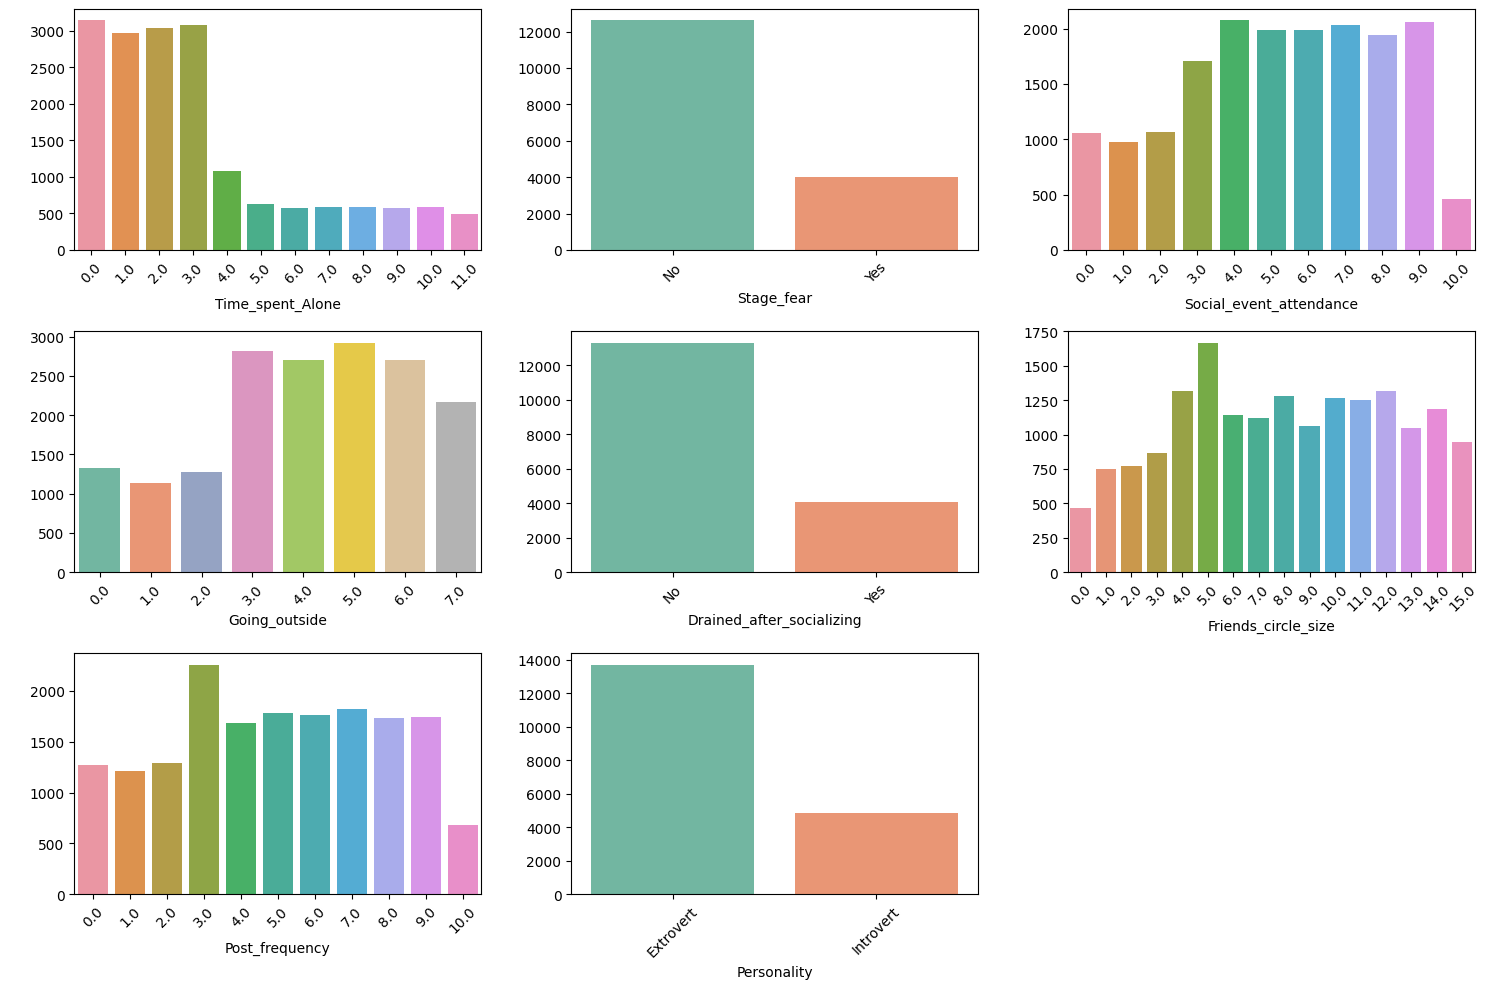

In [5]:
features = train.drop('id', axis = 1).columns.tolist()

sb.set_palette('Set2')
plt.figure(figsize=(15, 10))

# Loop through and plot each histogram
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    ax = sb.countplot(x=col, data=train)
    
    plt.xlabel(col)
    plt.ylabel(' ')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

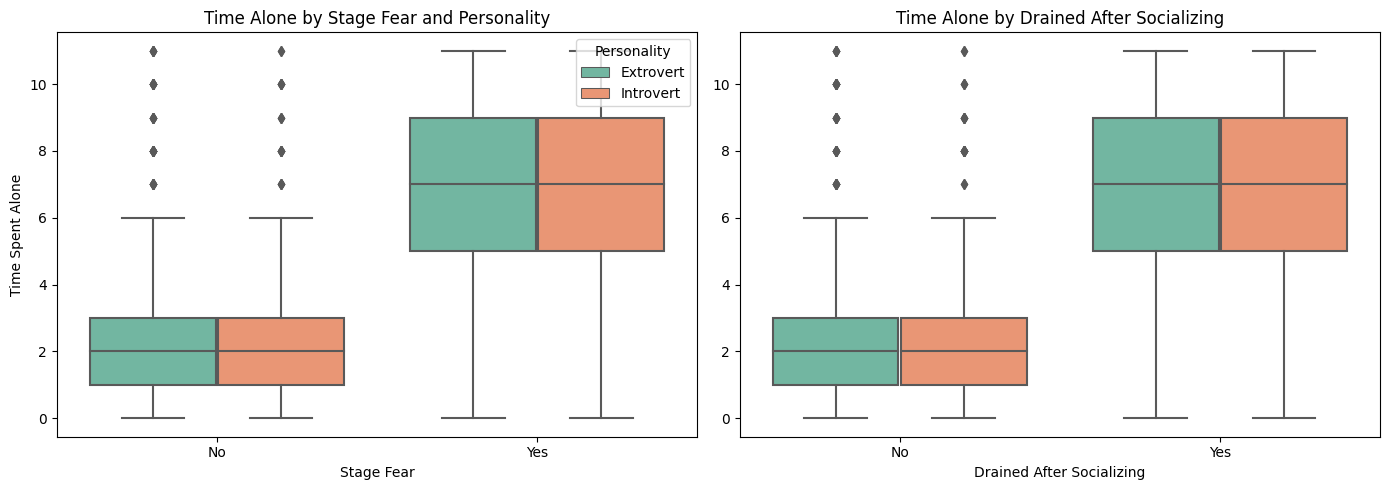

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Plot 1: Stage Fear
sb.boxplot(
    x='Stage_fear',
    y='Time_spent_Alone',
    hue='Personality',
    data=train,
    ax=axes[0]
)
axes[0].set_title('Time Alone by Stage Fear and Personality')
axes[0].set_xlabel('Stage Fear')
axes[0].set_ylabel('Time Spent Alone')

# Plot 2: Drained After Socializing
sb.boxplot(
    x='Drained_after_socializing',
    y='Time_spent_Alone',
    hue='Personality',
    data=train,
    ax=axes[1]
)
axes[1].set_title('Time Alone by Drained After Socializing')
axes[1].set_xlabel('Drained After Socializing')
axes[1].set_ylabel('')

# Handle legends (only once)
axes[0].legend(title='Personality', loc='upper right')
axes[1].legend_.remove()  # remove duplicate legend

plt.tight_layout()
plt.show()

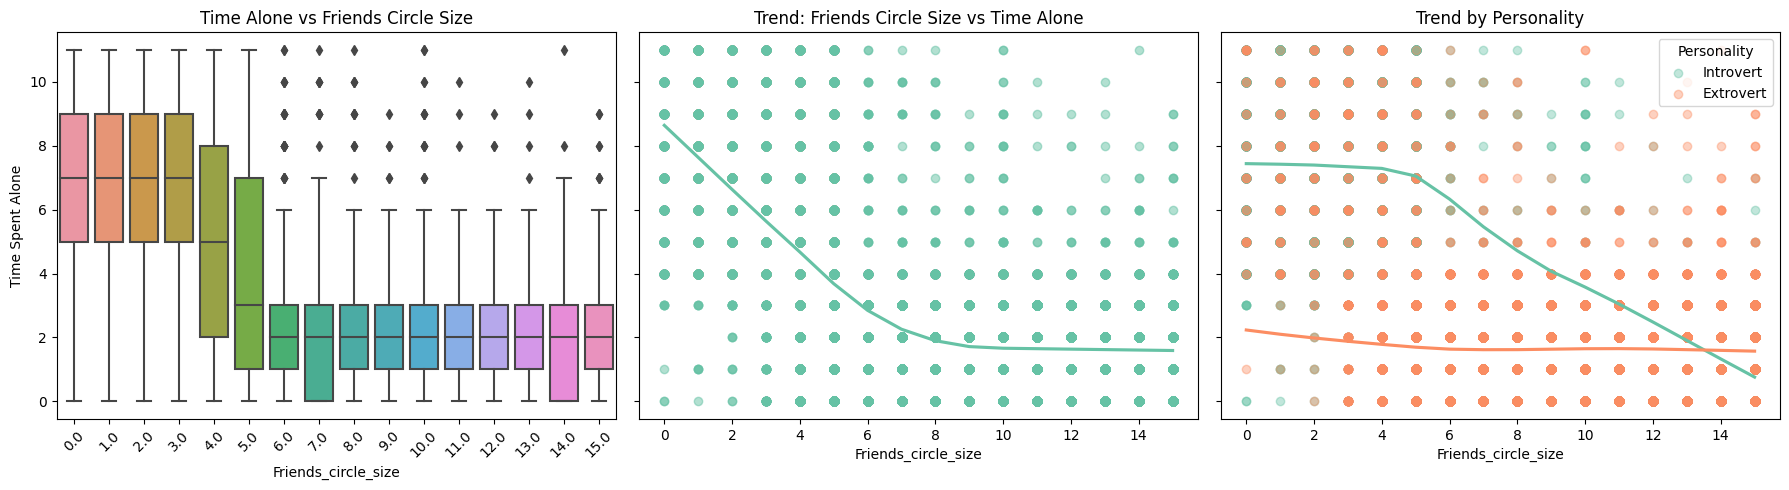

In [7]:
# 📊 COMPARATIVE PLOTS: Friends Circle Size vs Time Spent Alone

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sb.boxplot(
    x='Friends_circle_size',
    y='Time_spent_Alone',
    data=train,
    ax=axes[0]
)
axes[0].set_title('Time Alone vs Friends Circle Size')
axes[0].set_ylabel('Time Spent Alone')
axes[0].tick_params(axis='x', rotation=45)

sb.regplot(
    x='Friends_circle_size',
    y='Time_spent_Alone',
    data=train,
    lowess=True,
    scatter_kws={'alpha': 0.5},
    ax=axes[1]
)
axes[1].set_title('Trend: Friends Circle Size vs Time Alone')
axes[1].set_ylabel('')


for label, color in zip(['Introvert', 'Extrovert'], ['orange', 'green']):
    subset = train[train['Personality'] == label]
    sb.regplot(
        x='Friends_circle_size',
        y='Time_spent_Alone',
        data=subset,
        lowess=True,
        scatter_kws={'alpha': 0.4},
        label=label,
        ax=axes[2]
    )
axes[2].set_title('Trend by Personality')
axes[2].set_ylabel('')
axes[2].legend(title='Personality')

plt.tight_layout()
plt.show()


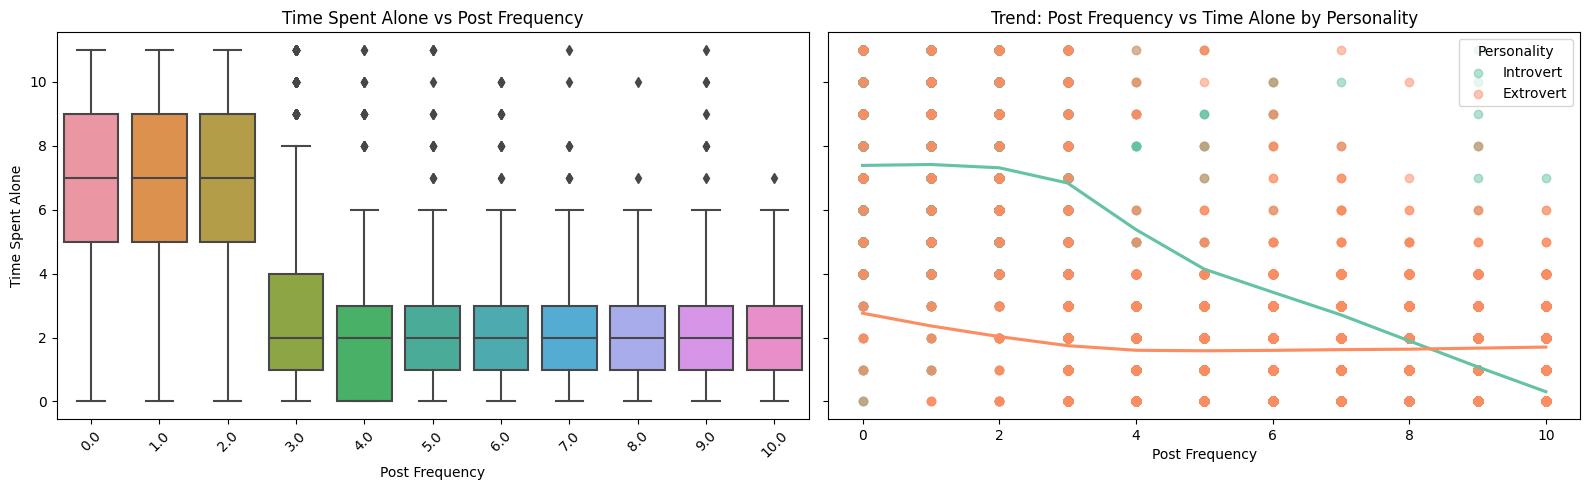

In [8]:
# 📊 TIME SPENT ALONE vs POST FREQUENCY 

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

sb.boxplot(
    x='Post_frequency',
    y='Time_spent_Alone',
    data=train,
    ax=axes[0]
)
axes[0].set_title('Time Spent Alone vs Post Frequency')
axes[0].set_xlabel('Post Frequency')
axes[0].set_ylabel('Time Spent Alone')
axes[0].tick_params(axis='x', rotation=45)


for label, color in zip(['Introvert', 'Extrovert'], ['orange', 'green']):
    subset = train[train['Personality'] == label]
    sb.regplot(
        x='Post_frequency',
        y='Time_spent_Alone',
        data=subset,
        lowess=True,
        scatter_kws={'alpha': 0.5},
        label=label,
        ax=axes[1]
    )

axes[1].set_title('Trend: Post Frequency vs Time Alone by Personality')
axes[1].set_xlabel('Post Frequency')
axes[1].set_ylabel('')
axes[1].legend(title='Personality')

plt.tight_layout()
plt.show()


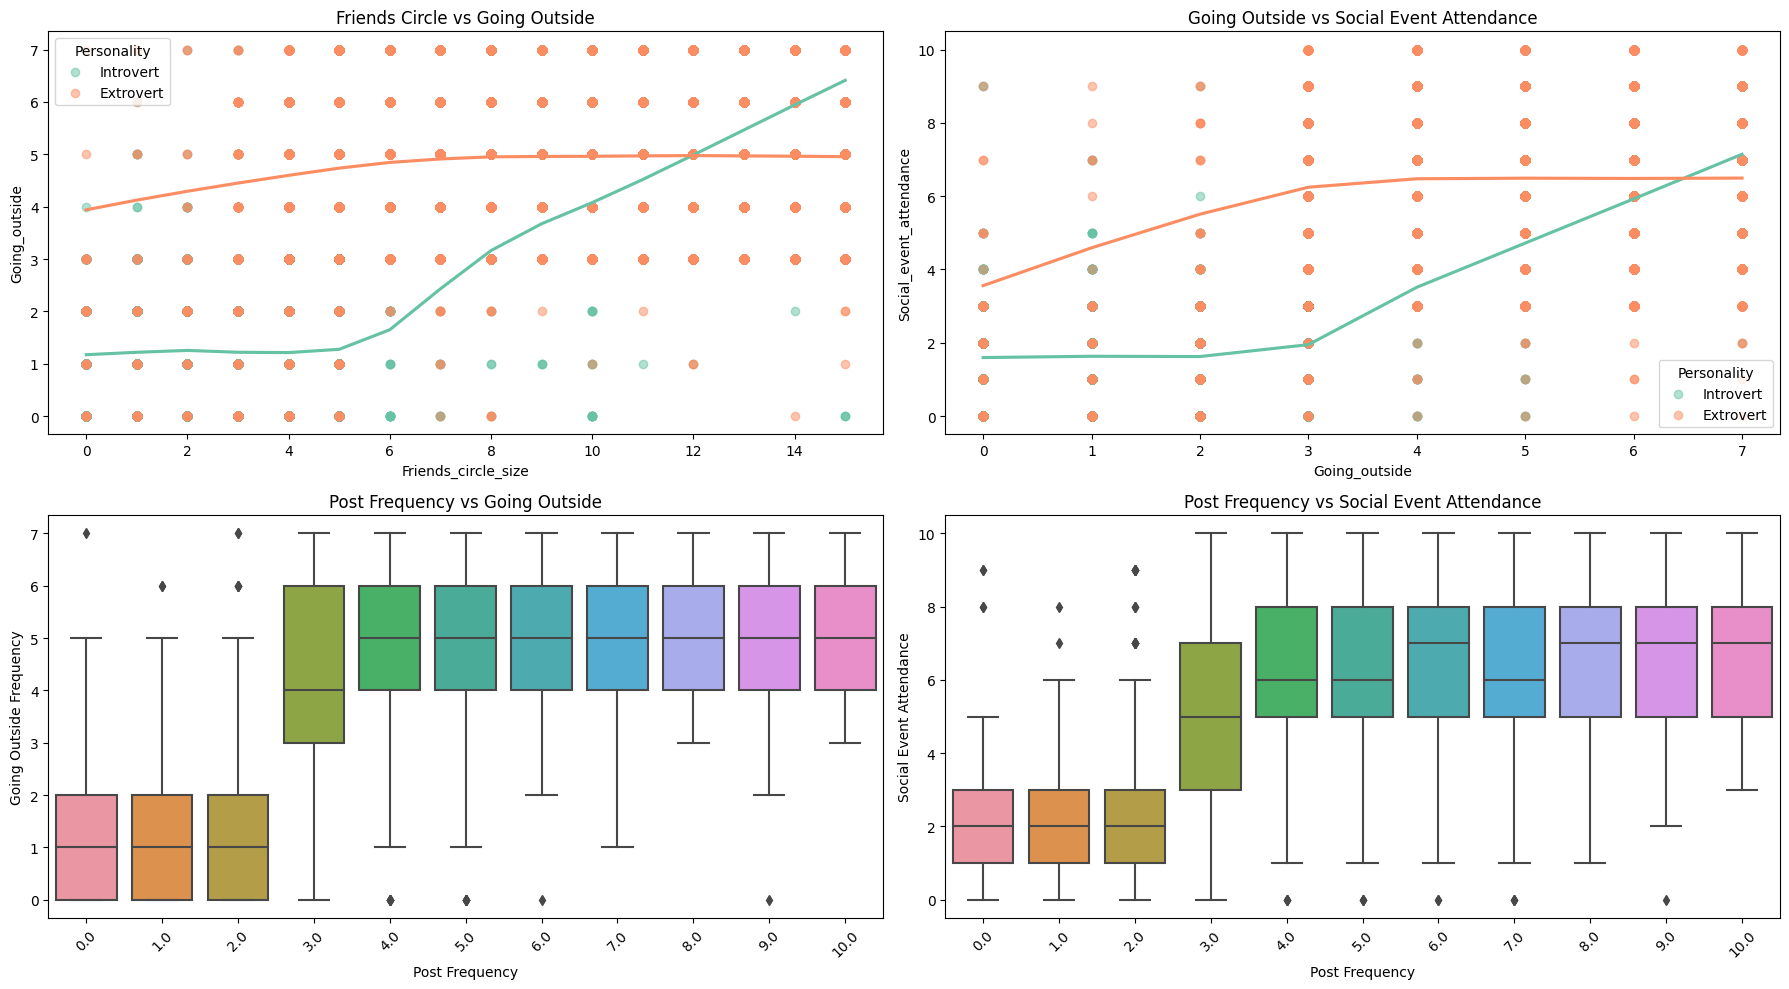

In [9]:
# 📊 2x2 Visualization Grid: Social Behavior Insights

fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey=False)

# Regression: Friends Circle Size vs Going Outside
for label, color in zip(['Introvert', 'Extrovert'], ['orange', 'green']):
    subset = train[train['Personality'] == label]
    sb.regplot(
        x='Friends_circle_size',
        y='Going_outside',
        data=subset,
        lowess=True,
        scatter_kws={'alpha': 0.5},
        label=label,
        ax=axes[0, 0]
    )
axes[0, 0].set_title('Friends Circle vs Going Outside')
axes[0, 0].legend(title='Personality')

# Regression: Going Outside vs Social Event Attendance
for label, color in zip(['Introvert', 'Extrovert'], ['orange', 'green']):
    subset = train[train['Personality'] == label]
    sb.regplot(
        x='Going_outside',
        y='Social_event_attendance',
        data=subset,
        lowess=True,
        scatter_kws={'alpha': 0.5},
        label=label,
        ax=axes[0, 1]
    )
axes[0, 1].set_title('Going Outside vs Social Event Attendance')
axes[0, 1].legend(title='Personality')

# Boxplot: Post Frequency vs Going Outside
sb.boxplot(
    x='Post_frequency',
    y='Going_outside',
    data=train,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Post Frequency vs Going Outside')
axes[1, 0].set_xlabel('Post Frequency')
axes[1, 0].set_ylabel('Going Outside Frequency')
axes[1, 0].tick_params(axis='x', rotation=45)

# Boxplot: Post Frequency vs Social Event Attendance
sb.boxplot(
    x='Post_frequency',
    y='Social_event_attendance',
    data=train,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Post Frequency vs Social Event Attendance')
axes[1, 1].set_xlabel('Post Frequency')
axes[1, 1].set_ylabel('Social Event Attendance')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Data Cleaning and Categorical Encoding

In [10]:
df_cols = [
    'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
    'Going_outside', 'Drained_after_socializing', 
    'Friends_circle_size', 'Post_frequency'
]

df = (
    orig_df.rename(columns={'Personality': 'match_p'})
           .drop_duplicates(subset=df_cols)
)


def merge_with_match_p(df, ref_df, merge_cols):
    merged_df = df.merge(ref_df, how='left', on=merge_cols)
    merged_df['match_p_null'] = merged_df['match_p'].isna().astype(int)
    return merged_df

train = merge_with_match_p(train, df, df_cols)
test_df = merge_with_match_p(test_df, df, df_cols)

train = train.drop_duplicates(subset=['id'], keep='first')
test_df = test_df.drop_duplicates(subset=['id'], keep='first')

In [11]:
train['match_p'] = train['match_p'].fillna('unknown')
test_df['match_p'] = test_df['match_p'].fillna('unknown')

train['Personality'] = train['Personality'].map({'Extrovert': 1, 'Introvert': 0})

## Categorical Feature Mapping
cat_col = ['match_p', 'Stage_fear', 'Drained_after_socializing']

def cat_encode(df, cat_col):
    for col in cat_col:
        if col == 'match_p':
            df[col] = df[col].map({'Extrovert': 2, 'Introvert': 1, 'unknown': 0})
        else:
            df[col] = df[col].map({'Yes': 1, 'No': 0})
    return df


train = cat_encode(train, cat_col)
test_df = cat_encode(test_df, cat_col)

In [12]:
for col in train.drop(columns = ['id', 'Personality']).columns:
    train[col] = train[col].fillna(train[col].mean())


for col in test_df.drop(columns = ['id']).columns:
    test_df[col] = test_df[col].fillna(test_df[col].mean())

# Model Training

In [13]:
x = train.drop(['Personality', 'id'], axis=1)
test  = test_df.drop('id', axis =1)
y = train['Personality']

In [14]:
counter = Counter(y)
neg = counter[0]
pos = counter[1]
scale_pos_weight = neg / pos

In [15]:
hgb = {'learning_rate': 0.03, 
       'max_leaf_nodes': 500, 
       'max_depth': 5, 
       'l2_regularization': 0.75, 
       'min_samples_leaf': 12, 
       'max_depth' : 5, 
       'random_state' : 42}


cat_sym_params = {'iterations': 1917, 'learning_rate': 0.00371215795906011, 'depth': 10, 
                  'l2_leaf_reg': 0.39370026876032066, 'random_strength': 0.49110906437943186, 
                  'bagging_temperature': 0.8653941572019647, "loss_function": "Logloss", 
                  "eval_metric": "AUC", "scale_pos_weight": scale_pos_weight, 
                  "grow_policy": "SymmetricTree","verbose": 0, "random_state": 42}



xtree = {'n_estimators': 1380, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt',
         "class_weight": "balanced", "random_state": 42, "n_jobs": -1}



lgb_model = {'objective' :'binary',  'n_estimators' : 300, 'max_depth' : 10, 'min_child_samples': 10, 'num_leaves' : 20,
                           'learning_rate': 0.010919705161662964,  'colsample_bytree': 0.881928717897877, 'metric' : 'auc',
                           'subsample' : 0.7015184751538656, 'random_state' : 42, 'verbosity' : 0}
                          

In [16]:
hgb_cl = HistGradientBoostingClassifier(loss="log_loss", **hgb)
cat_sym = CatBoostClassifier(**cat_sym_params)
xtra_cl = ExtraTreesClassifier(**xtree)
lgb = LGBMClassifier(**lgb_model)
#rf_clf = RandomForestClassifier(**rf_params)



stack_clf = StackingClassifier(
    estimators=[
        ('hgb', hgb_cl),
        ('cat_sym', cat_sym),
        ('xtra', xtra_cl),
        ('lgb', lgb),
        
    ],
    final_estimator=LogisticRegression(),
    cv=5,  
    n_jobs=-1,
    passthrough=False  
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
test_predict = np.zeros((len(test), 2))  

for fold, (train_index, val_index) in enumerate(skf.split(x, y)):
    print(f"\n✅ Training Fold {fold + 1}...")

    X_train, X_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    stack_clf.fit(X_train, y_train)
    y_pred_proba = stack_clf.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred_proba)
    print(f"Fold {fold+1} AUC: {auc:.4f}")
    auc_scores.append(auc)

    test_predict += stack_clf.predict_proba(test) / skf.n_splits

print(f"\n✅ Average AUC across folds: {np.mean(auc_scores):.4f}")



✅ Training Fold 1...
Fold 1 AUC: 0.9706

✅ Training Fold 2...
Fold 2 AUC: 0.9680

✅ Training Fold 3...
Fold 3 AUC: 0.9656

✅ Training Fold 4...
Fold 4 AUC: 0.9694

✅ Training Fold 5...
Fold 5 AUC: 0.9735

✅ Average AUC across folds: 0.9694


In [17]:
final_predict = np.argmax(test_predict, axis=1)


label_map = {1: 'Extrovert', 0: 'Introvert'}
final_predict = pd.Series(final_predict).map(label_map)

final_predict.head(5)

0    Extrovert
1    Introvert
2    Extrovert
3    Extrovert
4    Introvert
dtype: object

In [18]:
submission = pd.DataFrame({'id': test_df['id'], 'Personality': final_predict})
submission.to_csv('submission.csv', index=False)

#### 